### Phys 629, Fall 2023, University of Mississippi


# Lecture 11, Chapter 4: Classical Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.

***Exercises required for class participation are in <font color='red'>red</font>.***

## Fitting A Line To Data <a class="anchor" id="one"></a>


Continuing the theme of last lecture, let's look at one of the most common tasks in statistical inference: **fitting a line to data**. We won't always fit a straight line, but they are prevalent in astronomy since we're potentially examining data over several orders of magnitude. Hence power-law relationships ($y\propto x^\alpha$) become linear relationships in log-log space ($\ln y \propto \alpha\ln x + \mathrm{constant}$).

Assume the noise/scatter in our measurements (the residuals) is generated by a Gaussian process, i.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the measurement uncertainty, which we take to be the same for all points. The data model includes a linear relationship with two parameters $a,b$: hence the model is written as $M(a,b)$.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured. It is just the normal distribution:

$$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right). $$

The likelihood for all data points is given by the product over $N$ of these terms. Given our previous definitions we can then write down the $\ln L$ as

$$ \ln L(a, b) = \mathrm{constant} - \frac{1}{2} \sum_{i=1}^N \frac{(y_i - M(x_i))^2}{\sigma^2} = \mathrm{constant} - \frac{1}{2} \chi^2$$

This is the expression that we now ***maximize*** with respect to $a$ and $b$ to find ML estimators for those parameters. This is equivalent to ***minimizing*** the sum of the squares (the $\chi^2$) in a *least-squares method*.

<font color='red'>Execute this cell</font>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from astroML.datasets import fetch_hogg2010test

The following cell will read in some data and peform a least-squares (or $\chi^2$) fit of a linear relationship. It is minimizing the $\chi^2$ (since this is Gaussian data this means it's also maximizing the likelihood) for both $a$ (the slope) and $b$ (the $y$-intercept). 

The data contains some **poorly modeled outliers** too, which have very different uncertainties from what we assume. We'll look at the case without outliers first to build intuition. 

***The outlier points are the first 4 in the dataset.***

<font color='red'>Read through and understand the whole thing before you execute it.</font>

In [2]:
#------------------------------------------------------------
# Get data from AstroML: this includes outliers
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

# Define the standard squared-loss function.
# This is just another name for chi^2
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2)

# define a lambda function that defines the sum of squared errors.
# these lambda functions are useful!
# let's initially exclude the outliers by chopping off the first 4 points.
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x[4:], y=y[4:], 
                                      dy=dy[4:])

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106


We'll now include the outlier data points to see how they contaminate the fit, i.e., we don't need to exclude any of the points from our fit. <font color='red'>Complete and execute the following cell.</font> 

In [3]:
# complete to include the outliers
f_squared_outlier = lambda beta_outlier: squared_loss(beta_outlier[0], 
                                                      beta_outlier[1], 
                                                      x=x, y=y, dy=dy)


#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # complete for initial guess
beta_squared_outlier = optimize.fmin(f_squared_outlier, beta0)

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


<font color='red'>Complete in order to plot the regular and outlier fits on the same figure.</font> 

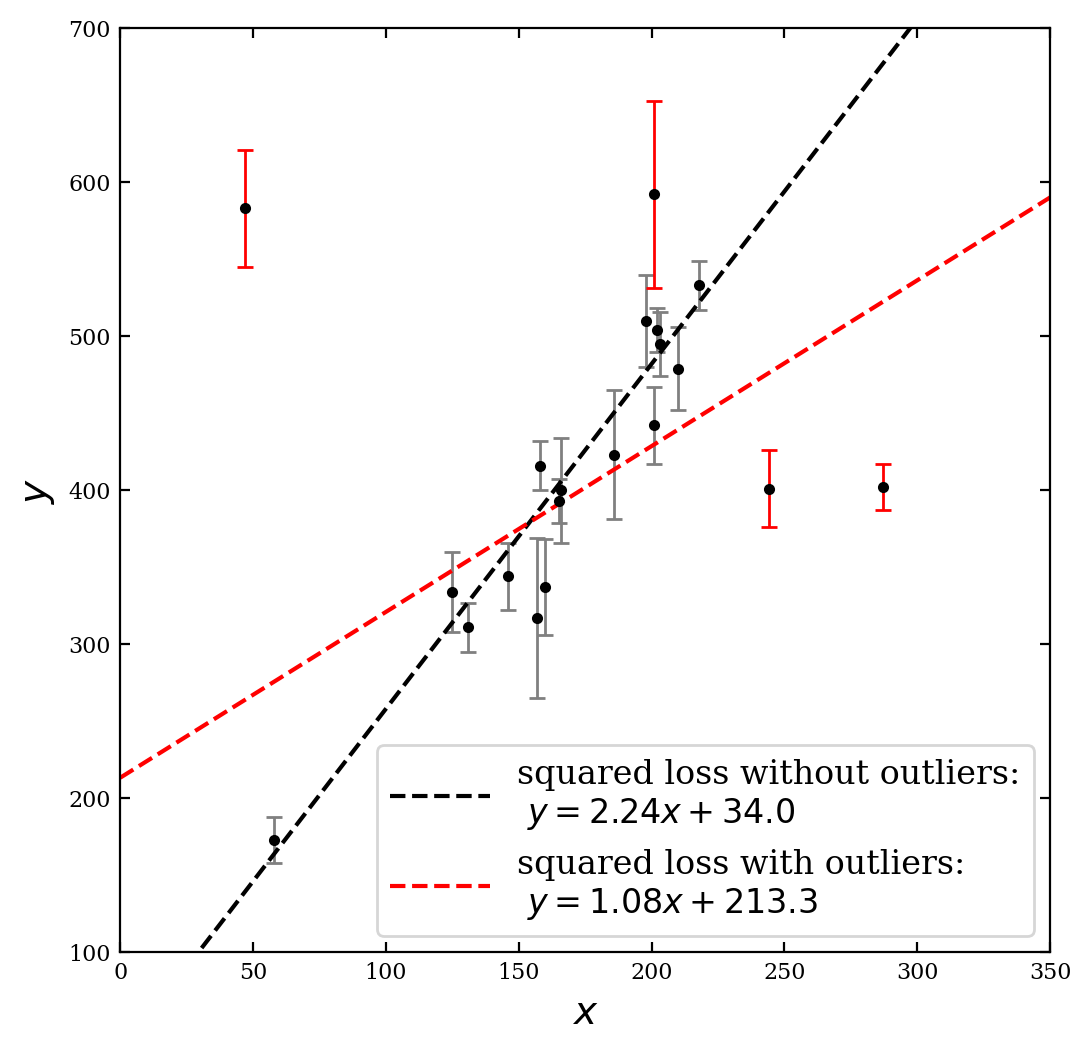

In [9]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[0:4], y[0:4], dy[0:4], 
            fmt='.k', lw=1, ecolor='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss without outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$',fontsize='14')
ax.set_ylabel('$y$',fontsize='14')
ax.legend(loc=4, prop=dict(size=12))

plt.show()

## Goodness Of Fit & Model Comparison <a class="anchor" id="two"></a>

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is. If the model is wrong, "best" might not be particularly revealing! Remember this acronym from the dawn of the computer age: ***GIGO = Garbage In, Garbage Out***. 

If we have a crappy model then we shouldn't expect a good fit to the data. For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial. But that won't help you predict future measurements.

We can describe the **goodness of fit** in words as simply the followng

> *The goodness of fit tells us whether or not it is likely to have obtained the maximum (log-)likelihood $\ln L^0$ by randomly drawing from the data.* 

Using the best-fit parameters of a model, the maximum likelihood value $L^0$ should not be an unlikely occurence. If it is, then our model is not describing the data well. Thus we need to know the *distribution* of $\ln L$ and not just its maximum. For the Gaussian case we have just described, we do a standard transform of variables and compute the so-called $z$ score for each data point (basically the number of standard deviations away from the mean that this point is), writing 

$$z_i = (x_i-\mu)/\sigma,$$ 

then

$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z_i^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

Here, $\chi^2$ is the thing whose distribution we discussed in early lectures.

**So for Gaussian uncertainties, $\ln L$ is distributed as $\chi^2$.**  

/home/amitesh/miniconda3/envs/phys629/lib/python3.8/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


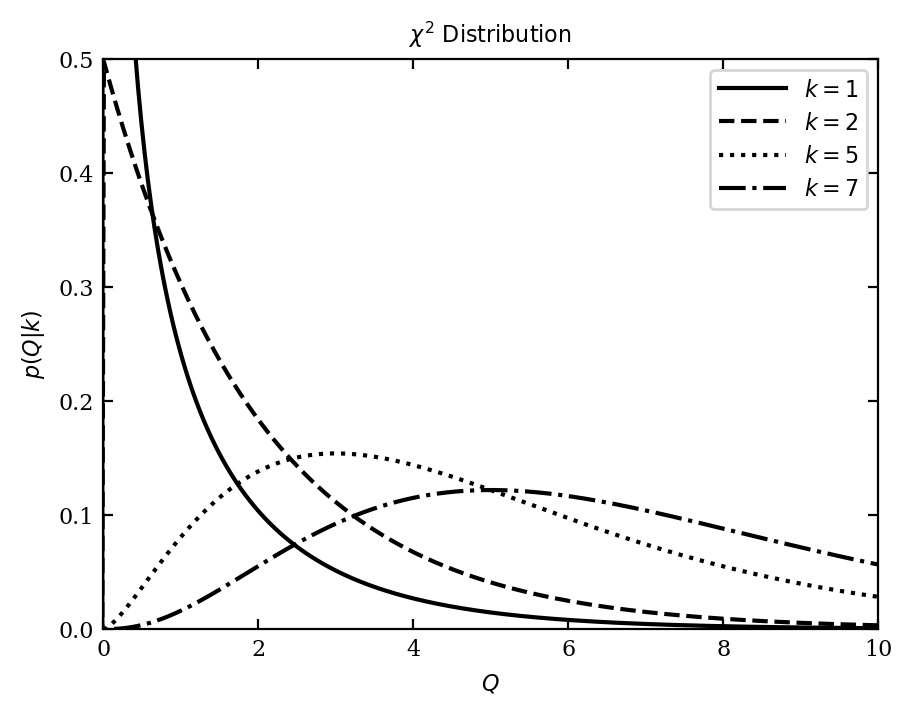

<Figure size 640x480 with 0 Axes>

In [6]:
%run /home/amitesh/phys629/phys629-fall-2023/lectures/scripts/fig_chi2_distribution.py

***The mean of the $\chi^2$ distribution is $N-k$ and its standard deviation is $\sqrt{2(N-k)}$.***

We define the $\chi^2$ per degree of freedom, $\chi^2_\mathrm{dof}$, as

$$\chi^2_\mathrm{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

where $k$ is the number of model parameters determined from the data.

- For a good fit, we would expect that $\chi^2_\mathrm{dof}\approx 1$. 
- If $\chi^2_\mathrm{dof}$ is significantly larger than 1, or $(\chi^2_\mathrm{dof}-1)>> \sqrt{2/(N-k)}$, then it is likely that we are not using the correct model.
- If data uncertainties are **(over)under-estimated** then this can lead to improbably **(low)high $\chi^2_\mathrm{dof}$**, as seen below.  

![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

<font color='red'>Read through and execute the following cell to compute $\chi^2_\mathrm{dof}-1$ for the line fitted without outliers and fitted with outliers. These will be compared to the standard deviation of the $\chi^2_\mathrm{dof}-1$ distributions.</font>

In [7]:
#------------------------------------------------------------
# Get data from AstroML: this includes outliers
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

# number of data points *without* outliers
N = x[4:].shape[0]
# number of data points *with* outliers
N_outlier = x.shape[0]
# number of model parameters (a,b)
k = 2 

# chi2 per dof *without* outliers
chi2 = squared_loss(beta_squared[0], 
                    beta_squared[1], 
                    x=x[4:], y=y[4:], dy=dy[4:])
chi2dof = chi2 / (N-k)

# chi2 per dof *with* outliers
chi2_outlier = squared_loss(beta_squared_outlier[0], 
                            beta_squared_outlier[1], 
                            x=x, y=y, dy=dy)
chi2dof_outlier = chi2_outlier / (N_outlier - k)

# without outliers
print(chi2dof-1, np.sqrt(2/(N-k)))

# with outliers
print(chi2dof_outlier-1, np.sqrt(2/(N_outlier - k)))

0.33434070794594706 0.3779644730092272
15.109095710111468 0.3333333333333333


### Model Comparison

The distribution of $\ln L$ can only be related to the $\chi^2$ distribution whenever the likelihood is Gaussian. For non-Gaussian likelihoods we can still rank different models in terms of their respectively computed maximum likelihood values, $L^0$. This is only really fair if the models have the same number of parameters.

Let's do that for the data above that contains outliers, both for a model based on the naive squared loss function ($\chi^2$), and a Huber loss function model.

We need a modified approach whenever the models we're comparing have different numbers of parameters. Such an approach should account for **model complexity** and **effectively penalize models with additional parameters that are not constrained by the data**. This is often called an ***Occam penalty***, because we're trying to incorporate [Occam's Razor](https://www.wikiwand.com/en/Occam%27s_razor#:~:text=Occam's%20razor%2C%20Ockham's%20razor%2C%20Ocham's,is%20usually%20the%20right%20one.).

> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*


We'll meet this in extensive detail later, especially in a Bayesian context. But a popular general-purpose tool for model comparison is the **Akaike Information Criterion** (AIC):

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points.

- For a Gaussian distribution, the first term is equal to $\chi^2$.
- **The model with lowest AIC is the most favored.**
- If all models are equally successful at fitting the data (equal $L^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins. 